/tmp/ipython-input-4150844706.py:152: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  posts_y = posts_df.set_index(date_col).resample('Y').size().rename('posts')
/tmp/ipython-input-4150844706.py:153: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  comments_y = comments_df.set_index(date_col).resample('Y').size().rename('comments')


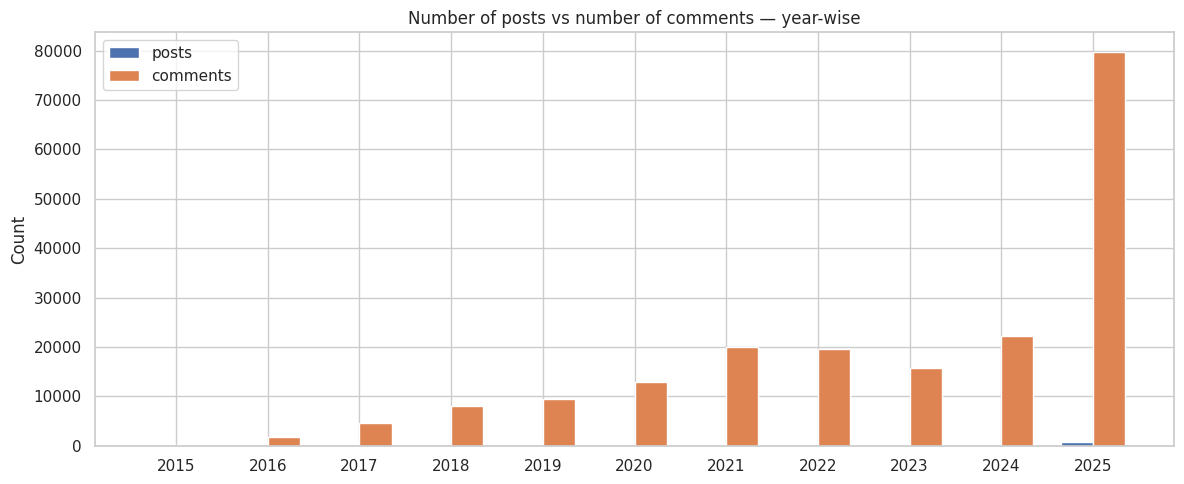


Topics for which graphs were created (topic_id : heading):
Topic 0 : The / To / And
Topic 1 : The / To / And
Topic 2 : Tesla & Models
Topic 3 : Tesla & Models
Topic 4 : The / And / To
Topic 5 : Battery / Range

Saved files to: /content/CSS-analysis-output
 - posts_vs_comments_yearly.png
 - topic_<id>_topwords.png (one per topic)
 - topic_summary_table_with_headings.csv
 - topic_labels.csv, topic_labels.json
 - topic_names.txt
 - topic_proportions_by_year_stacked_area.png
 - topic_trend_lines_with_headings.png
 - topic_heatmap_year_topic.png


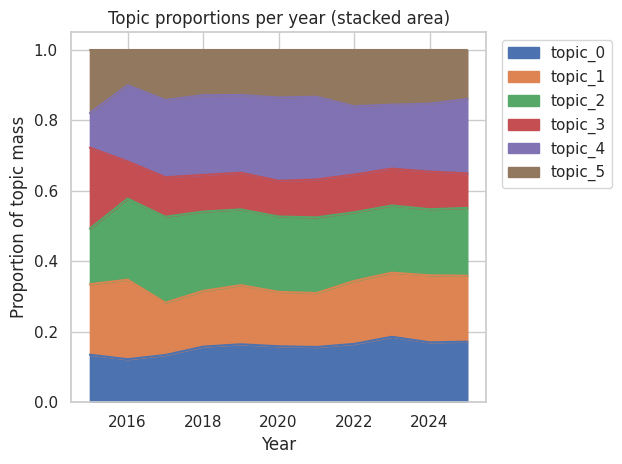

In [10]:
# analysis_plots_with_topic_headings.py
# Requirements:
# pip install pandas numpy matplotlib seaborn

import ast
import json
from pathlib import Path
from collections import Counter
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams.update({'figure.autolayout': True})

# ---------- FILE PATHS (explicit) ----------
DOC_CSV = Path('/content/doc_level_sent_topics.csv')
POSTS_CSV = Path('/content/posts_cleaned_with_sent.csv')
COMMENTS_CSV = Path('/content/comments_cleaned_with_sent.csv')

OUT_DIR = Path('/content/CSS-analysis-output')
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---------- HELPERS ----------
def parse_topic_dist_cell(x):
    if pd.isna(x):
        return None
    s = str(x).strip()
    try:
        obj = json.loads(s)
        if isinstance(obj, list):
            return np.array(obj, dtype=float)
    except Exception:
        pass
    try:
        obj = ast.literal_eval(s)
    except Exception:
        obj = None
    if isinstance(obj, dict):
        return obj
    if isinstance(obj, (list, tuple)) and len(obj) and isinstance(obj[0], (list, tuple)):
        return list(obj)
    nums = re.findall(r"[-+]?\d*\.\d+|\d+", s)
    if nums:
        return np.array([float(n) for n in nums], dtype=float)
    return None

def to_full_vector(parsed, num_topics):
    vec = np.zeros(num_topics, dtype=float)
    if parsed is None:
        return vec
    if isinstance(parsed, np.ndarray):
        L = min(len(parsed), num_topics)
        vec[:L] = parsed[:L]
        return vec
    if isinstance(parsed, dict):
        for k, v in parsed.items():
            vec[int(k)] = float(v)
        return vec
    if isinstance(parsed, (list, tuple)):
        for a in parsed:
            if len(a) >= 2:
                vec[int(a[0])] = float(a[1])
        return vec
    return vec

def simple_tokenize(text):
    text = str(text).lower()
    toks = re.findall(r'\b[a-z0-9]{2,}\b', text)
    return toks

def derive_topic_heading(top_words, mapping_rules):
    """
    top_words: list of words (ordered by freq)
    mapping_rules: dict label -> list of keyword substrings
    Return best label or None if no strong match.
    Heuristic: count how many top_words contain any keyword substring; choose label with highest hits.
    Tie-break: prefer label with higher-weighted occurrences (earlier top words count more).
    """
    scores = {}
    for label, keywords in mapping_rules.items():
        scores[label] = 0.0
    for rank, w in enumerate(top_words, start=1):
        # weight earlier words more: inverse rank
        weight = 1.0 / rank
        for label, keywords in mapping_rules.items():
            for kw in keywords:
                if kw in w:
                    scores[label] += weight
    # choose best non-zero score
    best_label, best_score = None, 0.0
    for k, v in scores.items():
        if v > best_score:
            best_label, best_score = k, v
    # only accept meaningful match
    if best_score > 0:
        return best_label
    return None

# ---------- KEYWORD-BASED LABEL MAPPING (customize as needed) ----------
KEYWORD_LABELS = {
    "Charging infrastructure": ["charg", "charger", "supercharg", "station", "chargepoint", "plug"],
    "Battery / Range": ["battery", "range", "km", "mile", "miles", "capacity", "soc", "charge"],
    "Pricing / Cost": ["price", "cost", "msrp", "expens", "cheaper", "discount", "tax"],
    "Tesla & Models": ["tesla", "elon", "model", "model3", "modelx", "modely"],
    "Autonomy / Autopilot": ["autopilot", "autonom", "fsd", "selfdriv", "driverless"],
    "Maintenance & Service": ["service", "repair", "warranty", "recall", "dealer"],
    "Performance": ["accel", "0-60", "hp", "torque", "topspeed", "speed"],
    "Safety": ["safety", "crash", "airbag", "accident", "recall"],
    "Policy / Incentives": ["policy", "regul", "gov", "subsidy", "incentiv"],
    "Environment / Emissions": ["green", "emiss", "environment", "sustain"],
    "Availability / Deliveries": ["deliver", "inventory", "stock", "available", "leadtime"],
    "Charging anxiety / Range anxiety": ["anxi", "rangeanxi", "range-anxi", "panic"],
    "Other / Misc": []
}

# ---------- LOAD CSVs ----------
doc_df = pd.read_csv(DOC_CSV)
posts = pd.read_csv(POSTS_CSV)
comments = pd.read_csv(COMMENTS_CSV)

# ---------- ATTACH created_utc to doc_df ----------
if {'doc_id','kind'}.issubset(doc_df.columns):
    posts_created = pd.Series(posts['created_utc'].astype(str).values, index=range(len(posts)))
    comments_created = pd.Series(comments['created_utc'].astype(str).values, index=range(len(comments)))

    def map_created(row):
        try:
            idx = int(row['doc_id'])
        except:
            return pd.NA
        if row['kind'] == 'post':
            return posts_created.get(idx, pd.NA)
        elif row['kind'] == 'comment':
            return comments_created.get(idx, pd.NA)
        else:
            return pd.NA

    doc_df['created_utc'] = doc_df.apply(map_created, axis=1)
    doc_df = doc_df.dropna(subset=['created_utc']).reset_index(drop=True)
else:
    raise RuntimeError("doc_level file missing 'doc_id' or 'kind' columns")

# ---------- POSTS vs COMMENTS: YEAR-WISE side-by-side bar plot ----------
def plot_posts_vs_comments_yearly(posts_df, comments_df, date_col='created_utc', outpath=None):
    posts_df = posts_df.copy()
    comments_df = comments_df.copy()
    posts_df[date_col] = pd.to_datetime(posts_df[date_col], errors='coerce')
    comments_df[date_col] = pd.to_datetime(comments_df[date_col], errors='coerce')
    posts_y = posts_df.set_index(date_col).resample('Y').size().rename('posts')
    comments_y = comments_df.set_index(date_col).resample('Y').size().rename('comments')
    merged = pd.concat([posts_y, comments_y], axis=1).fillna(0).astype(int)
    merged.index = merged.index.year
    fig, ax = plt.subplots(figsize=(12,5))
    width = 0.35
    x = np.arange(len(merged))
    ax.bar(x - width/2, merged['posts'].values, width=width, label='posts')
    ax.bar(x + width/2, merged['comments'].values, width=width, label='comments')
    ax.set_xticks(x)
    ax.set_xticklabels(merged.index.astype(str), rotation=0)
    ax.set_ylabel('Count')
    ax.set_title('Number of posts vs number of comments — year-wise')
    ax.legend()
    plt.tight_layout()
    if outpath:
        fig.savefig(outpath, dpi=200, bbox_inches='tight')
    plt.show()

plot_posts_vs_comments_yearly(posts, comments, outpath=OUT_DIR / 'posts_vs_comments_yearly.png')

# ---------- TOPIC-WORD BAR PLOTS and HEADINGS ----------
if 'dominant_topic' not in doc_df.columns:
    raise RuntimeError("doc-level CSV missing 'dominant_topic' column")

grouped = doc_df.groupby('dominant_topic')['text'].apply(lambda rows: " ".join(map(str, rows))).reset_index()
top_n = 20
topics_created = []  # collect (topic_id, top_words_list, doc_count, heading_label)

for _, row in grouped.iterrows():
    topic_id = int(row['dominant_topic'])
    text_blob = row['text']
    toks = simple_tokenize(text_blob)
    freq = Counter(toks)
    top = freq.most_common(top_n)
    if not top:
        continue
    words, counts = zip(*top)
    # plot
    fig, ax = plt.subplots(figsize=(8,6))
    ax.barh(range(len(words)-1, -1, -1), counts, align='center')
    ax.set_yticks(range(len(words)-1, -1, -1))
    ax.set_yticklabels(words)
    ax.set_xlabel('Token frequency')
    ax.set_title(f'Topic {topic_id} — top {top_n} words')
    plt.tight_layout()
    out_png = OUT_DIR / f'topic_{topic_id}_topwords.png'
    fig.savefig(out_png, dpi=200, bbox_inches='tight')
    plt.close(fig)

    topwords_list = [w for w,_ in top]
    topwords_short = ", ".join(topwords_list[:10])
    doc_count = int((doc_df['dominant_topic'] == topic_id).sum())

    # derive heading using rules; fallback to generated label from top words
    heading = derive_topic_heading(topwords_list[:15], KEYWORD_LABELS)
    if heading is None:
        # fallback: make a concise label from first 3 top words
        heading = " / ".join([w.capitalize() for w in topwords_list[:3]])
    topics_created.append((topic_id, topwords_list, doc_count, heading))

# Save topic summary table and list of topic names (with headings)
summary_rows = []
with open(OUT_DIR / 'topic_names.txt', 'w', encoding='utf-8') as f:
    for topic_id, topwords_list, doc_count, heading in sorted(topics_created, key=lambda x: x[0]):
        topwords_short = ", ".join(topwords_list[:10])
        summary_rows.append({'topic': int(topic_id), 'doc_count': doc_count, 'top_words': topwords_short, 'heading': heading})
        f.write(f"Topic {topic_id} — {heading}: {topwords_short}\n")

summary_df = pd.DataFrame(summary_rows).sort_values('topic').reset_index(drop=True)
summary_df.to_csv(OUT_DIR / 'topic_summary_table_with_headings.csv', index=False)

# Also save labels as a separate CSV for easy mapping
labels_df = summary_df[['topic', 'heading', 'top_words', 'doc_count']]
labels_df.to_csv(OUT_DIR / 'topic_labels.csv', index=False)
# Save JSON mapping as well
labels_df.set_index('topic')['heading'].to_json(OUT_DIR / 'topic_labels.json', orient='index')

# Print to stdout
print("\nTopics for which graphs were created (topic_id : heading):")
for topic_id, topwords_list, doc_count, heading in sorted(topics_created, key=lambda x: x[0]):
    print(f"Topic {topic_id} : {heading}")

# ---------- PER-YEAR TOPIC ANALYSIS (stacked area, trends, heatmap) ----------
if 'topic_dist' not in doc_df.columns:
    raise RuntimeError("doc-level CSV missing 'topic_dist' column")

parsed = doc_df['topic_dist'].apply(parse_topic_dist_cell)
max_topic_id = -1
max_len_array = 0
for p in parsed.dropna():
    if isinstance(p, dict):
        max_topic_id = max(max_topic_id, max(map(int, p.keys())))
    elif isinstance(p, (list, tuple)) and len(p) and isinstance(p[0], (list, tuple)):
        max_topic_id = max(max_topic_id, max(int(x[0]) for x in p))
    elif isinstance(p, np.ndarray):
        max_len_array = max(max_len_array, len(p))
num_topics = max(max_topic_id + 1, max_len_array, 0)
if num_topics == 0:
    raise RuntimeError("Could not infer number of topics from topic_dist column")

mat = np.vstack([to_full_vector(p, num_topics) for p in parsed.apply(lambda x: x if x is not None else None)])
topic_cols = [f'topic_{i}' for i in range(num_topics)]
topic_probs_df = pd.DataFrame(mat, columns=topic_cols, index=doc_df.index)

doc_df['created_utc'] = pd.to_datetime(doc_df['created_utc'], errors='coerce')
doc_df['year'] = doc_df['created_utc'].dt.year
merged = pd.concat([doc_df[['year']], topic_probs_df], axis=1).dropna(subset=['year'])
agg_sum = merged.groupby('year')[topic_cols].sum().sort_index()
agg_prop = agg_sum.div(agg_sum.sum(axis=1), axis=0).fillna(0)

# stacked area chart
fig = plt.figure(figsize=(12,6))
agg_prop.plot.area()
plt.xlabel('Year')
plt.ylabel('Proportion of topic mass')
plt.title('Topic proportions per year (stacked area)')
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
fig.savefig(OUT_DIR / 'topic_proportions_by_year_stacked_area.png', dpi=200, bbox_inches='tight')
plt.close(fig)

# per-topic trend lines (use human headings when available)
fig, ax = plt.subplots(figsize=(10,6))
for i, col in enumerate(agg_prop.columns):
    # find heading if exists
    h = labels_df.loc[labels_df['topic'] == int(col.split('_')[1]), 'heading'] if 'labels_df' in locals() else None
    label = h.values[0] if (h is not None and len(h) > 0) else col
    ax.plot(agg_prop.index, agg_prop[col], marker='o', label=label)
ax.set_xlabel('Year')
ax.set_ylabel('Proportion')
ax.set_title('Per-topic trend lines')
ax.legend(bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
fig.savefig(OUT_DIR / 'topic_trend_lines_with_headings.png', dpi=200, bbox_inches='tight')
plt.close(fig)

# heatmap of raw sums
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(agg_sum.T, annot=False, cmap='viridis', ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Topic')
ax.set_title('Topic distribution heatmap (year x topic)')
plt.tight_layout()
fig.savefig(OUT_DIR / 'topic_heatmap_year_topic.png', dpi=200, bbox_inches='tight')
plt.close(fig)

# Save numeric outputs
agg_prop.to_csv(OUT_DIR / 'topic_proportions_by_year.csv')
agg_sum.to_csv(OUT_DIR / 'topic_sums_by_year.csv')

print("\nSaved files to:", OUT_DIR)
print(" - posts_vs_comments_yearly.png")
print(" - topic_<id>_topwords.png (one per topic)")
print(" - topic_summary_table_with_headings.csv")
print(" - topic_labels.csv, topic_labels.json")
print(" - topic_names.txt")
print(" - topic_proportions_by_year_stacked_area.png")
print(" - topic_trend_lines_with_headings.png")
print(" - topic_heatmap_year_topic.png")


Loading files...
Loaded: doc_level rows=195433, posts=1281, comments=194152


/tmp/ipython-input-229300314.py:114: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  posts_y = posts_df.set_index(date_col).resample('Y').size().rename('posts')
/tmp/ipython-input-229300314.py:115: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  comments_y = comments_df.set_index(date_col).resample('Y').size().rename('comments')


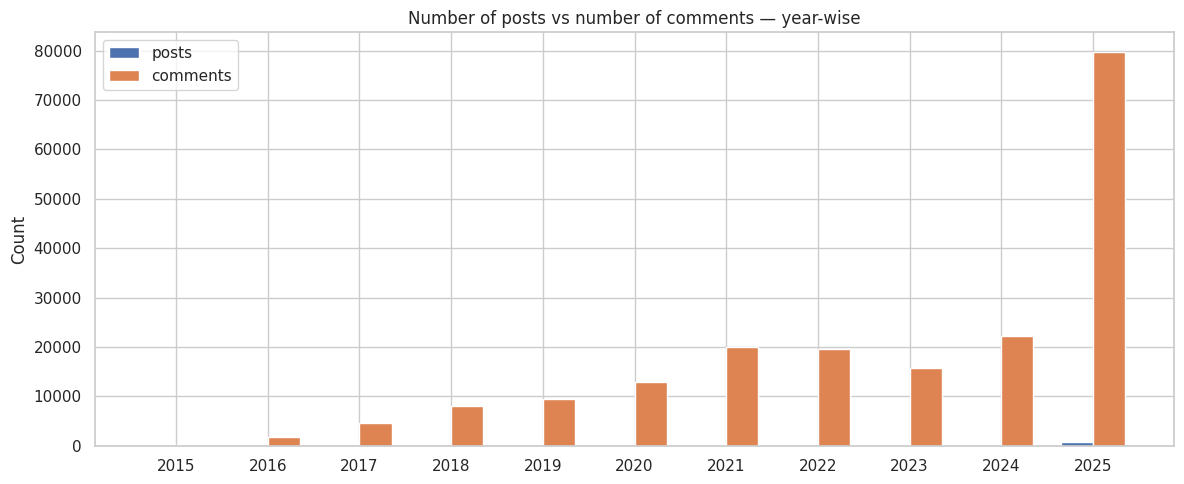

Saved posts_vs_comments_yearly.png


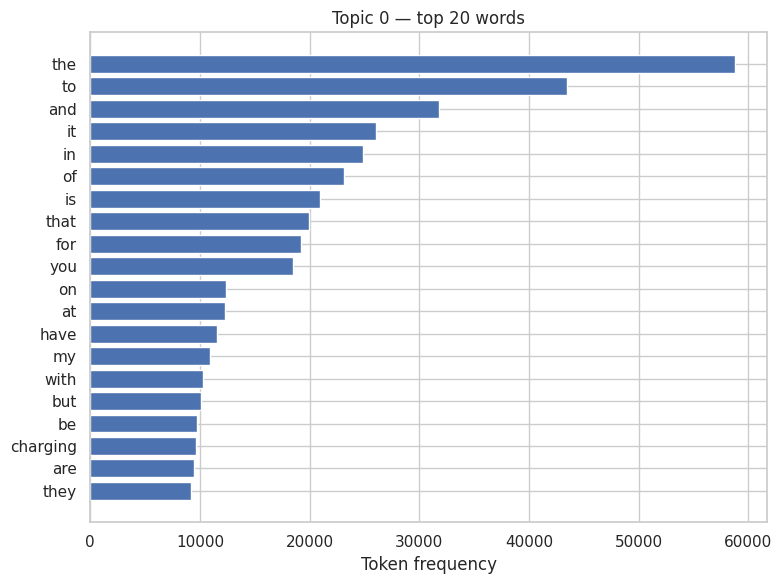

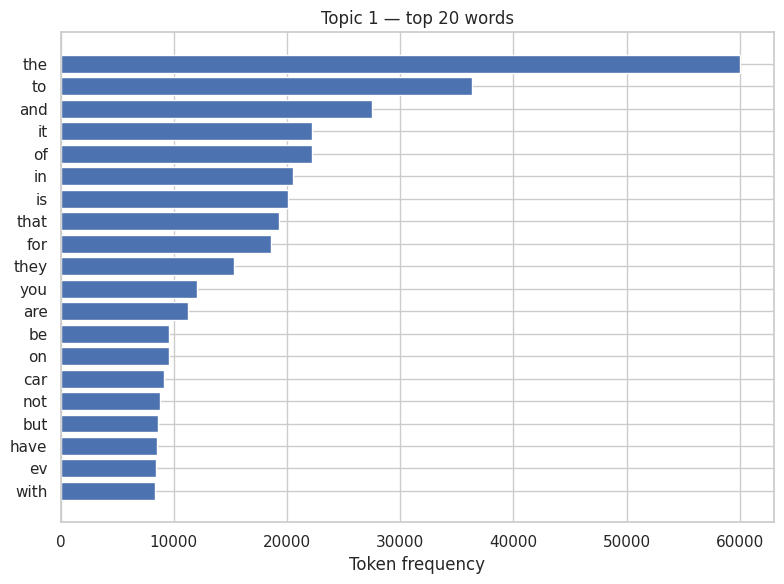

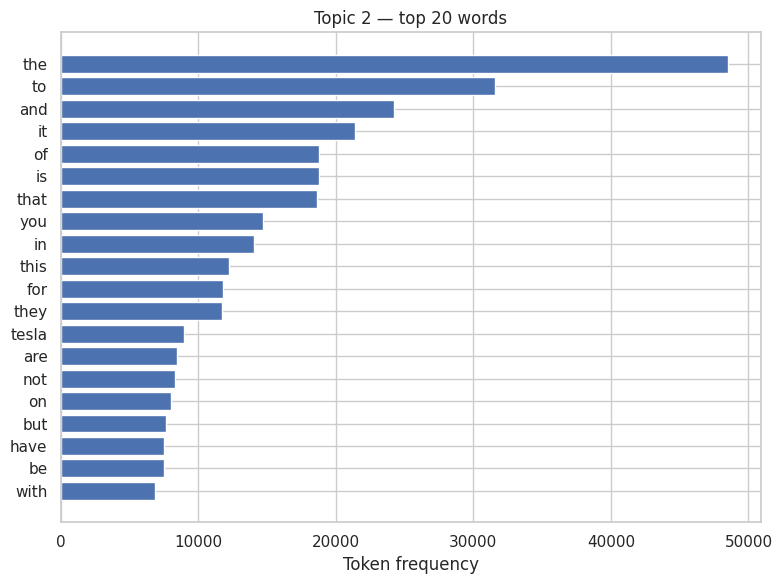

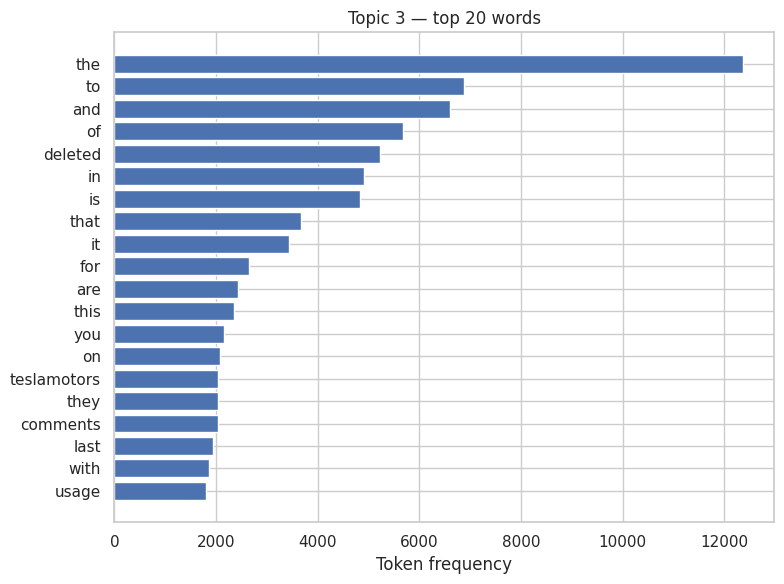

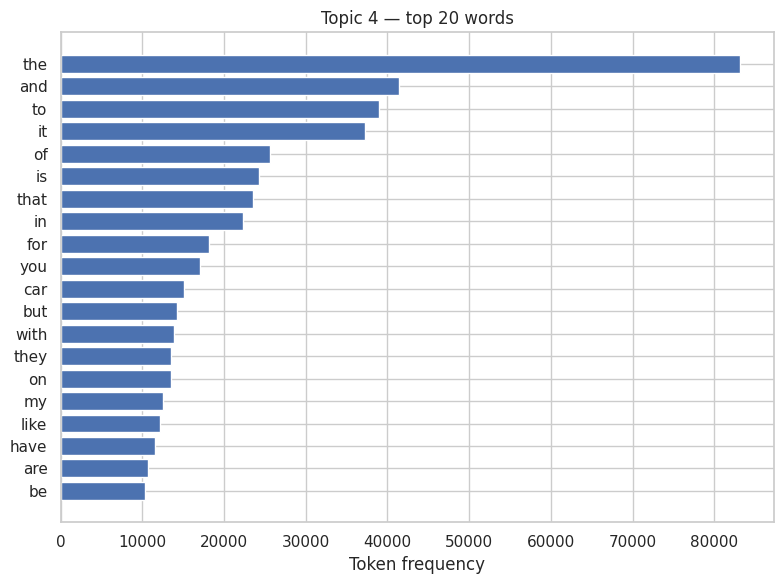

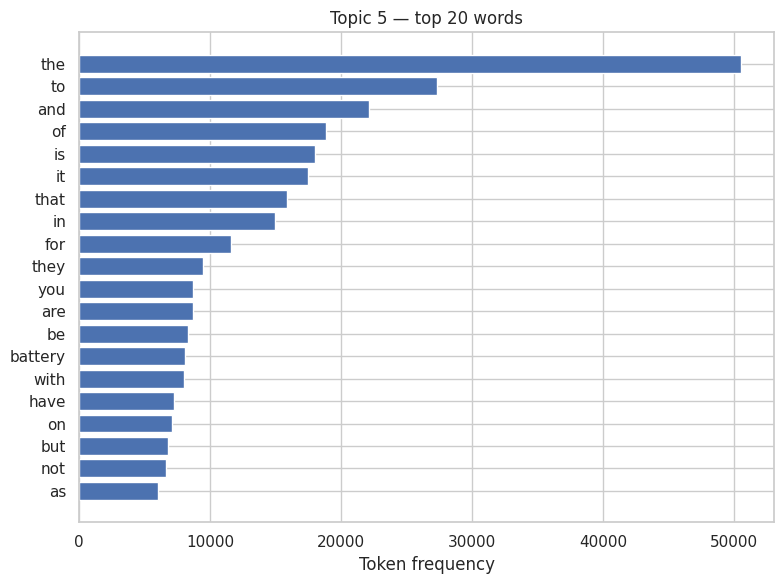

Saved topic_summary_table.csv
Saved topic_names.txt with the list of topics and top words

Topics for which graphs were created:
Topic 0: the, to, and, it, in, of, is, that, for, you
Topic 1: the, to, and, it, of, in, is, that, for, they
Topic 2: the, to, and, it, of, is, that, you, in, this
Topic 3: the, to, and, of, deleted, in, is, that, it, for
Topic 4: the, and, to, it, of, is, that, in, for, you
Topic 5: the, to, and, of, is, it, that, in, for, they
Inferred num_topics = 6


<Figure size 1200x600 with 0 Axes>

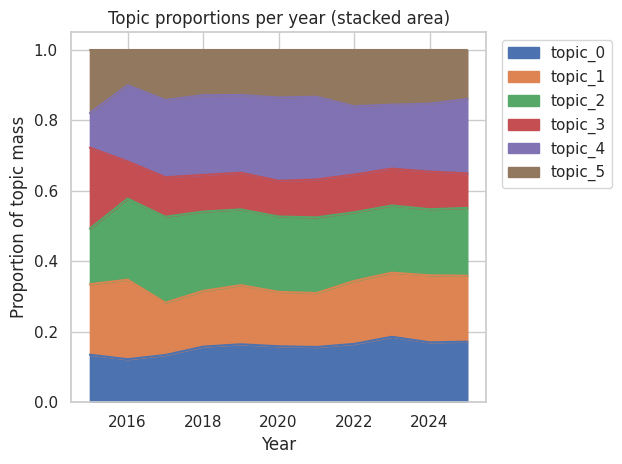

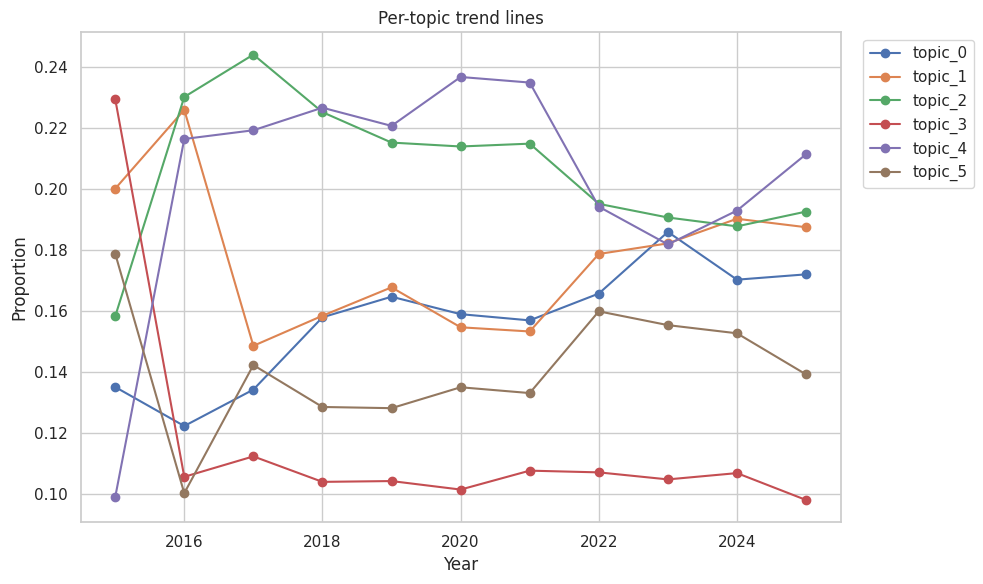

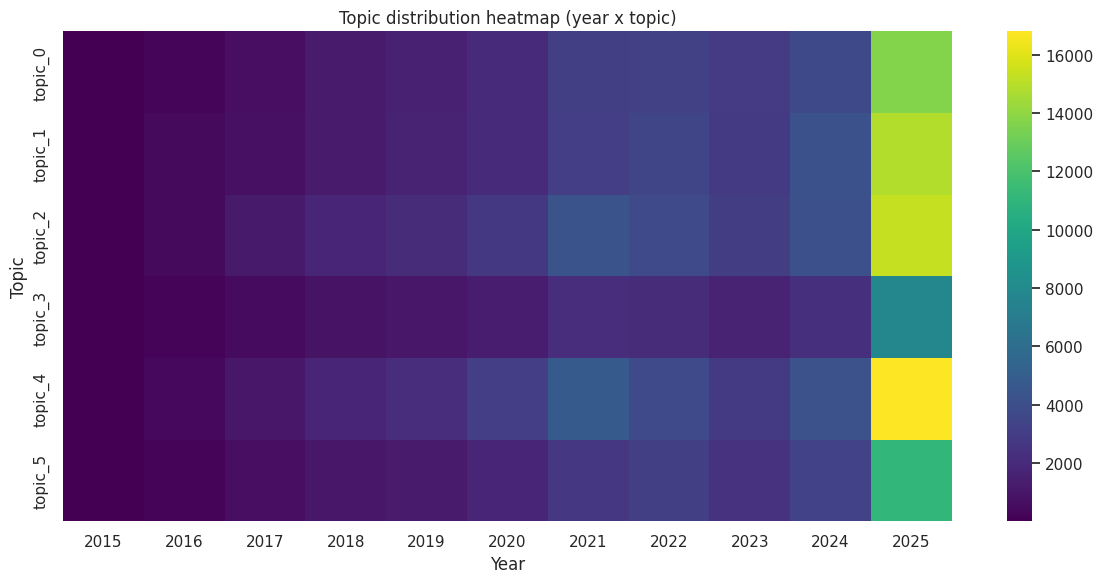

Saved per-year topic CSVs to /content/CSS-analysis-output

Done. Files created in: /content/CSS-analysis-output
 - posts_vs_comments_yearly.png
 - topic_{id}_topwords.png (one per topic)
 - topic_summary_table.csv
 - topic_names.txt (list of Topic <id>: <top words>)
 - topic_proportions_by_year_stacked_area.png
 - topic_trend_lines.png
 - topic_heatmap_year_topic.png


In [11]:
# analysis_plots_for_CSS_yearly.py
# Requirements:
# pip install pandas numpy matplotlib seaborn

import ast
import json
from pathlib import Path
from collections import Counter
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams.update({'figure.autolayout': True})

# ---------- FILE PATHS (explicit) ----------
DOC_CSV = Path('/content/doc_level_sent_topics.csv')
POSTS_CSV = Path('/content/posts_cleaned_with_sent.csv')
COMMENTS_CSV = Path('/content/comments_cleaned_with_sent.csv')

OUT_DIR = Path('/content/CSS-analysis-output')
OUT_DIR.mkdir(parents=True, exist_ok=True)


# ---------- HELPERS ----------
def parse_topic_dist_cell(x):
    """Parse topic_dist cell into dict/list/np.array as available."""
    if pd.isna(x):
        return None
    s = str(x).strip()
    # Try JSON list
    try:
        obj = json.loads(s)
        if isinstance(obj, list):
            return np.array(obj, dtype=float)
    except Exception:
        pass
    # Try python literal eval
    try:
        obj = ast.literal_eval(s)
    except Exception:
        obj = None
    if isinstance(obj, dict):
        return obj
    if isinstance(obj, (list, tuple)) and len(obj) and isinstance(obj[0], (list, tuple)):
        return list(obj)
    # fallback: extract numbers (handles plain number lists)
    nums = re.findall(r"[-+]?\d*\.\d+|\d+", s)
    if nums:
        return np.array([float(n) for n in nums], dtype=float)
    return None

def to_full_vector(parsed, num_topics):
    vec = np.zeros(num_topics, dtype=float)
    if parsed is None:
        return vec
    if isinstance(parsed, np.ndarray):
        L = min(len(parsed), num_topics)
        vec[:L] = parsed[:L]
        return vec
    if isinstance(parsed, dict):
        for k,v in parsed.items():
            vec[int(k)] = float(v)
        return vec
    if isinstance(parsed, (list, tuple)):
        for a in parsed:
            if len(a) >= 2:
                vec[int(a[0])] = float(a[1])
        return vec
    return vec

def simple_tokenize(text):
    text = str(text).lower()
    toks = re.findall(r'\b[a-z0-9]{2,}\b', text)
    return toks

# ---------- LOAD CSVs ----------
print("Loading files...")
doc_df = pd.read_csv(DOC_CSV)
posts = pd.read_csv(POSTS_CSV)
comments = pd.read_csv(COMMENTS_CSV)
print(f"Loaded: doc_level rows={len(doc_df)}, posts={len(posts)}, comments={len(comments)}")

# ---------- ATTACH created_utc to doc_df ----------
if {'doc_id','kind'}.issubset(doc_df.columns):
    posts_created = pd.Series(posts['created_utc'].astype(str).values, index=range(len(posts)))
    comments_created = pd.Series(comments['created_utc'].astype(str).values, index=range(len(comments)))

    def map_created(row):
        try:
            idx = int(row['doc_id'])
        except:
            return pd.NA
        if row['kind'] == 'post':
            return posts_created.get(idx, pd.NA)
        elif row['kind'] == 'comment':
            return comments_created.get(idx, pd.NA)
        else:
            return pd.NA

    doc_df['created_utc'] = doc_df.apply(map_created, axis=1)
    doc_df = doc_df.dropna(subset=['created_utc']).reset_index(drop=True)
else:
    raise RuntimeError("doc_level file missing 'doc_id' or 'kind' columns")

# ---------- POSTS vs COMMENTS: YEAR-WISE side-by-side bar plot ----------
def plot_posts_vs_comments_yearly(posts_df, comments_df, date_col='created_utc', outpath=None):
    posts_df = posts_df.copy()
    comments_df = comments_df.copy()
    posts_df[date_col] = pd.to_datetime(posts_df[date_col], errors='coerce')
    comments_df[date_col] = pd.to_datetime(comments_df[date_col], errors='coerce')
    posts_y = posts_df.set_index(date_col).resample('Y').size().rename('posts')
    comments_y = comments_df.set_index(date_col).resample('Y').size().rename('comments')
    merged = pd.concat([posts_y, comments_y], axis=1).fillna(0).astype(int)
    merged.index = merged.index.year  # use years as index values

    # side-by-side bars per year
    fig, ax = plt.subplots(figsize=(12,5))
    width = 0.35
    x = np.arange(len(merged))
    ax.bar(x - width/2, merged['posts'].values, width=width, label='posts')
    ax.bar(x + width/2, merged['comments'].values, width=width, label='comments')
    ax.set_xticks(x)
    ax.set_xticklabels(merged.index.astype(str), rotation=0)
    ax.set_ylabel('Count')
    ax.set_title('Number of posts vs number of comments — year-wise')
    ax.legend()
    plt.tight_layout()
    if outpath:
        fig.savefig(outpath, dpi=200, bbox_inches='tight')
    plt.show()

plot_posts_vs_comments_yearly(posts, comments, outpath=OUT_DIR / 'posts_vs_comments_yearly.png')
print("Saved posts_vs_comments_yearly.png")

# ---------- TOPIC-WORD BAR PLOTS (from doc-level dominant_topic + text) ----------
if 'dominant_topic' not in doc_df.columns:
    raise RuntimeError("doc-level CSV missing 'dominant_topic' column")

grouped = doc_df.groupby('dominant_topic')['text'].apply(lambda rows: " ".join(map(str, rows))).reset_index()
top_n = 20
topics_created = []  # collect topic ids and top words

for _, row in grouped.iterrows():
    topic_id = int(row['dominant_topic'])
    text_blob = row['text']
    toks = simple_tokenize(text_blob)
    freq = Counter(toks)
    top = freq.most_common(top_n)
    if not top:
        continue
    words, counts = zip(*top)
    fig, ax = plt.subplots(figsize=(8,6))
    ax.barh(range(len(words)-1, -1, -1), counts, align='center')
    ax.set_yticks(range(len(words)-1, -1, -1))
    ax.set_yticklabels(words)
    ax.set_xlabel('Token frequency')
    ax.set_title(f'Topic {topic_id} — top {top_n} words')
    plt.tight_layout()
    out_png = OUT_DIR / f'topic_{topic_id}_topwords.png'
    fig.savefig(out_png, dpi=200, bbox_inches='tight')
    plt.show()

    topwords_short = ", ".join(words[:10])
    topics_created.append((topic_id, topwords_short))

# Save topic summary table and list of topic names
summary_rows = []
for topic_id, topwords_short in sorted(topics_created, key=lambda x: x[0]):
    doc_count = int((doc_df['dominant_topic']==topic_id).sum())
    summary_rows.append({'topic': int(topic_id), 'doc_count': doc_count, 'top_words': topwords_short})
summary_df = pd.DataFrame(summary_rows).sort_values('topic').reset_index(drop=True)
summary_df.to_csv(OUT_DIR / 'topic_summary_table.csv', index=False)
print("Saved topic_summary_table.csv")

with open(OUT_DIR / 'topic_names.txt', 'w', encoding='utf-8') as f:
    for topic_id, topwords_short in sorted(topics_created, key=lambda x: x[0]):
        line = f"Topic {topic_id}: {topwords_short}"
        f.write(line + "\n")
print("Saved topic_names.txt with the list of topics and top words")

# Also print the topics list to stdout
print("\nTopics for which graphs were created:")
for topic_id, topwords_short in sorted(topics_created, key=lambda x: x[0]):
    print(f"Topic {topic_id}: {topwords_short}")

# ---------- PER-YEAR TOPIC ANALYSIS (stacked area, trends, heatmap) ----------
if 'topic_dist' not in doc_df.columns:
    raise RuntimeError("doc-level CSV missing 'topic_dist' column")

parsed = doc_df['topic_dist'].apply(parse_topic_dist_cell)
# infer number of topics
max_topic_id = -1
max_len_array = 0
for p in parsed.dropna():
    if isinstance(p, dict):
        max_topic_id = max(max_topic_id, max(map(int,p.keys())))
    elif isinstance(p, (list, tuple)) and len(p) and isinstance(p[0], (list,tuple)):
        max_topic_id = max(max_topic_id, max(int(x[0]) for x in p))
    elif isinstance(p, np.ndarray):
        max_len_array = max(max_len_array, len(p))
num_topics = max(max_topic_id+1, max_len_array, 0)
if num_topics == 0:
    raise RuntimeError("Could not infer number of topics from topic_dist column")
print("Inferred num_topics =", num_topics)

mat = np.vstack([to_full_vector(p, num_topics) for p in parsed.apply(lambda x: x if x is not None else None)])
topic_cols = [f'topic_{i}' for i in range(num_topics)]
topic_probs_df = pd.DataFrame(mat, columns=topic_cols, index=doc_df.index)

doc_df['created_utc'] = pd.to_datetime(doc_df['created_utc'], errors='coerce')
doc_df['year'] = doc_df['created_utc'].dt.year
merged = pd.concat([doc_df[['year']], topic_probs_df], axis=1).dropna(subset=['year'])
agg_sum = merged.groupby('year')[topic_cols].sum().sort_index()
agg_prop = agg_sum.div(agg_sum.sum(axis=1), axis=0).fillna(0)

# stacked area chart
fig = plt.figure(figsize=(12,6))
agg_prop.plot.area()
plt.xlabel('Year')
plt.ylabel('Proportion of topic mass')
plt.title('Topic proportions per year (stacked area)')
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
fig.savefig(OUT_DIR / 'topic_proportions_by_year_stacked_area.png', dpi=200, bbox_inches='tight')
plt.show()

# per-topic trend lines
fig, ax = plt.subplots(figsize=(10,6))
for col in agg_prop.columns:
    ax.plot(agg_prop.index, agg_prop[col], marker='o', label=col)
ax.set_xlabel('Year')
ax.set_ylabel('Proportion')
ax.set_title('Per-topic trend lines')
ax.legend(bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
fig.savefig(OUT_DIR / 'topic_trend_lines.png', dpi=200, bbox_inches='tight')
plt.show()

# heatmap of raw sums
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(agg_sum.T, annot=False, cmap='viridis', ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Topic')
ax.set_title('Topic distribution heatmap (year x topic)')
plt.tight_layout()
fig.savefig(OUT_DIR / 'topic_heatmap_year_topic.png', dpi=200, bbox_inches='tight')
plt.show()

# Save numeric outputs
agg_prop.to_csv(OUT_DIR / 'topic_proportions_by_year.csv')
agg_sum.to_csv(OUT_DIR / 'topic_sums_by_year.csv')
print("Saved per-year topic CSVs to", OUT_DIR)

print("\nDone. Files created in:", OUT_DIR)
print(" - posts_vs_comments_yearly.png")
print(" - topic_{id}_topwords.png (one per topic)")
print(" - topic_summary_table.csv")
print(" - topic_names.txt (list of Topic <id>: <top words>)")
print(" - topic_proportions_by_year_stacked_area.png")
print(" - topic_trend_lines.png")
print(" - topic_heatmap_year_topic.png")


In [6]:
!pip install pandas numpy matplotlib seaborn astor